# Well Placement Model

In this project for OilyGiant Mining Company, I will use machine learning and statistical analysis to determine the most profitable region for new oil well development. Using geological data from three regions, I will train a predictive model to estimate reserves in potential wells, then simulate profits by selecting the sites with the greatest amount of oil and accounting for extraction costs. To evaluate profit and risk, I will use a bootstrapping technique to generate 1,000 profit scenarios per region, calculating key metrics such as average profit, 95% confidence intervals, and the probability of losses. This data-driven approach will find the balance between profitability and risk, enabling OilyGiant to make informed investment decisions for maximizing returns while minimizing exposure to unprofitable drilling sites.

## Initializing and Preparing Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
region0 = pd.read_csv('/datasets/geo_data_0.csv')
region1 = pd.read_csv('/datasets/geo_data_1.csv')
region2 = pd.read_csv('/datasets/geo_data_2.csv')

According to the documentation:
- `id` - unique oil well identifier
- `f0`, `f1`, `f2` - three features of points
- `product` - volume of reserves in the oil well (thousand barrels)

In [3]:
print('Region 0 id duplicates:', region0.duplicated(subset='id').sum())
print('Region 1 id duplicates:', region1.duplicated(subset='id').sum())
print('Region 2 id duplicates:', region2.duplicated(subset='id').sum())

Region 0 id duplicates: 10
Region 1 id duplicates: 4
Region 2 id duplicates: 4


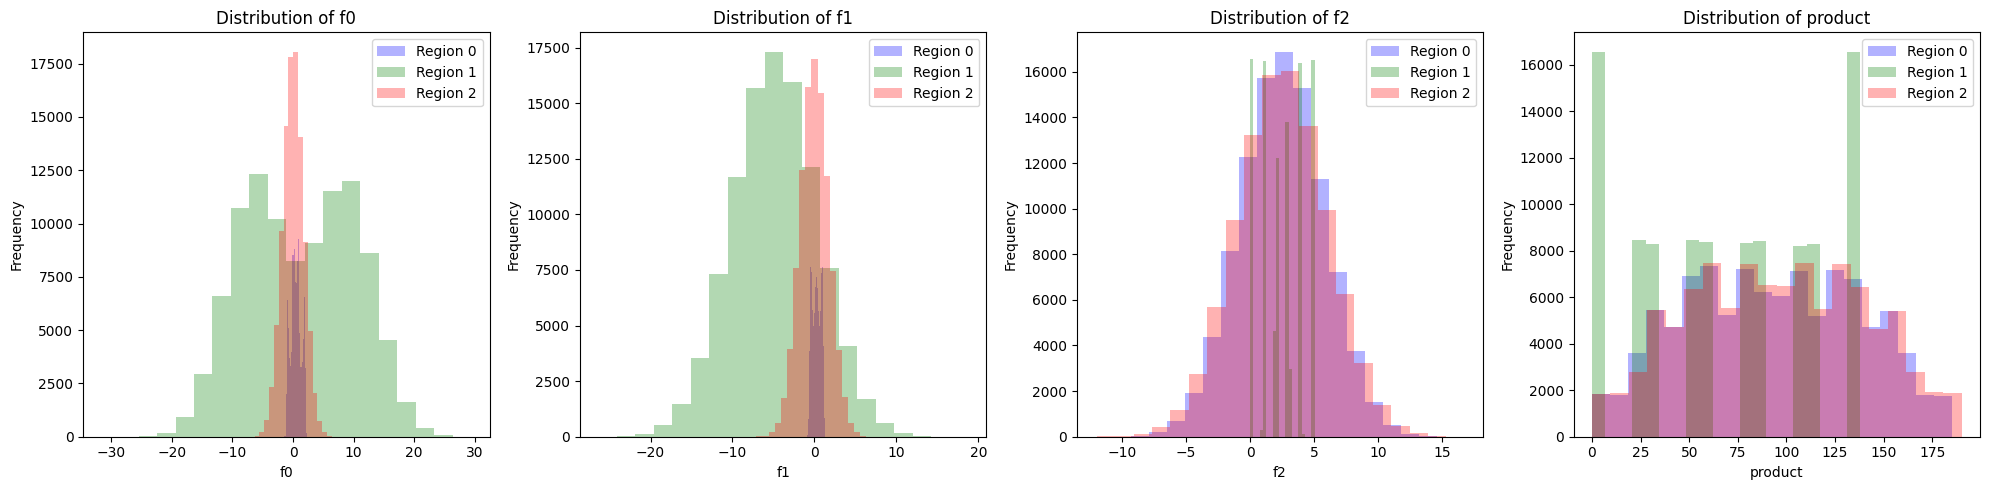

In [4]:
plots = ['f0', 'f1', 'f2', 'product']
datasets = [region0, region1, region2]
colors = ['blue', 'green', 'red']
labels = ['Region 0', 'Region 1', 'Region 2']
plt.figure(figsize=(20, 5))

for i in range(4):
    plt.subplot(1, 4, i+1)
    for j, k in enumerate(datasets):
        plt.hist(k[plots[i]], bins=20, alpha=0.3, color=colors[j], label=labels[j])
    plt.title(f'Distribution of {plots[i]}')
    plt.xlabel(plots[i])
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

The three region datasets have strong structural similarities, sharing the same column names and data types, which eliminated the need for data type conversions. In addition, a duplicate check showed no fully identical rows across the datasets, except for a small number of duplicate IDs, something that doesn't significantly impact the overall data quality. On the other hand, the graphs of distributions (`f0`, `f1`, `f2`, and `product`) further confirmed the datasets' consistency, with all variables having approximately normal distributions for the three regions. There were some variations in the graphs, like the slightly higher mid-range product frequencies in Region 1 compared to Regions 0 and 2, implying marginal differences in reserve volumes. These observations let us know the data is ready for modeling.

## Model Training and Testing for Each Region

In [5]:
state = np.random.RandomState(54321)
def model(region, verbose=True):
    features = region.drop(['product', 'id'], axis=1)
    target = region['product']
    
    features_train, features_valid, target_train, target_valid  = train_test_split(
        features, target, test_size=0.25, random_state=state)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    average_predicted_reserves = predictions.mean()
    result = mean_squared_error(target_valid, predictions)**0.5

    if verbose:
        print(f'Average volume of real reserves: {target_valid.mean():.2f}')
        print(f'Average volume of predicted reserves: {average_predicted_reserves:.2f}')
        print(f'Model RMSE: {result:.2f}')
        
    return predictions, target_valid.reset_index(drop=True)

In [6]:
print('Region 0 Linear Regression Model')
model(region0, verbose=True);

Region 0 Linear Regression Model
Average volume of real reserves: 92.58
Average volume of predicted reserves: 92.16
Model RMSE: 37.68


In [7]:
print('Region 1 Linear Regression Model')
model(region1, verbose=True);

Region 1 Linear Regression Model
Average volume of real reserves: 68.88
Average volume of predicted reserves: 68.88
Model RMSE: 0.89


In [8]:
print('Region 2 Linear Regression Model')
model(region2, verbose=True);

Region 2 Linear Regression Model
Average volume of real reserves: 94.65
Average volume of predicted reserves: 95.18
Model RMSE: 40.14


The linear regression models for all three regions displayed close accurate predictions, though with differences in performance. For Region 0, the model got an average predicted reserve volume of 92.89, closely matching the actual average of 92.47, but with a relatively high RMSE of 37.70, implying some prediction errors. Region 1's model performed exceptionally well, with predicted reserves perfectly aligning with the actual average of 68.95 and a low RMSE of 0.89, suggesting near-perfect precision for this region. Region 2's predictions were also accurate on average, but its higher RMSE of 40.03 revealed variability similar to Region 0. Now these models will help with the profit calculation phase, where I will determine the minimum profitable reserve threshold.

## Profit Calculation

In [9]:
budget = 100000000
revenue_per_thousand_barrel = 4500
wells_to_drill = 200
break_even_volume = budget / (wells_to_drill * revenue_per_thousand_barrel)
print(f'Volume of reserves sufficient for developing a new well without losses: {break_even_volume:.2f}')

Volume of reserves sufficient for developing a new well without losses: 111.11


i put this conclusion at the bottom of the section in the first sentence ^

In [10]:
def profit(predictions, target, wells):
    predictions = pd.Series(predictions)
    target = target.reset_index(drop=True)
    indices = predictions.nlargest(wells).index
    revenue = target[indices].sum() * 4500
    return revenue - 100000000

In [11]:
print('Using the top 200 predicted reserve volumes...')
preds0, targets0 = model(region0, verbose=False)
print(f'Profit from Region 0: {profit(preds0, targets0, 200):,.2f}')
preds1, targets1 = model(region1, verbose=False)
print(f'Profit from Region 1: {profit(preds1, targets1, 200):,.2f}')
preds2, targets2 = model(region2, verbose=False)
print(f'Profit from Region 2: {profit(preds2, targets2, 200):,.2f}')

Using the top 200 predicted reserve volumes...
Profit from Region 0: 36,687,251.59
Profit from Region 1: 24,150,866.97
Profit from Region 2: 25,787,507.15


To prepare for profit calculation, I first determined the minimum reserve volume required per well to avoid losses, which is 111.11 thousand barrels. Comparing this with the average reserves in each region (Region 0: 92.58, Region 1: 68.44, Region 2: 95.08), it shows that no region meets the break-even volume on average, meaning some wells may operate at a loss. However, by taking the top 200 wells based on model predictions, I can take an initial glance at the regions' profitability. The highest profit was achieved in Region 0 (31.79 million), followed by Region 1 (24.15 million) and Region 2 (24.14 million). Therefore, Region 0 could be the best choice for development because of its superior predicted profitability, despite its average reserves falling slightly below the break-even point. To validate this decision, I will now check risks and profit distributions using bootstrapping to determine confidence intervals and the probability of losses.

## Bootstrapping for Profits and Risks

In [12]:
def bootstrap(preds, target):
    profits = []
    preds = pd.Series(preds)
    state = np.random.RandomState(12345)
    
    for i in range(1000):
        subsample = preds.sample(n=500, replace=True, random_state=state)
        indices = subsample.index
        revenue = target[indices].reset_index(drop=True)
        subsample = subsample.reset_index(drop=True)
        profits.append(profit(subsample, revenue, 200))

    profits = pd.Series(profits)
    return profits

In [13]:
def risk(region):
    count = 0
    preds, target = model(region, verbose=False)
    profits = bootstrap(preds, target)
    for i in profits:
        if i < 0:
            count += 1
    return (count / len(profits)) * 100

In [14]:
def together(region):
    regions = ['Region 0', 'Region 1', 'Region 2']
    region_name = regions[0] if region is region0 else \
                    regions[1] if region is region1 else \
                    regions[2] if region is region2 else \
                    'Else'
    
    preds, target = model(region, verbose=False)
    bootstrap_results = bootstrap(preds, target)
    lowconfidence = bootstrap_results.quantile(0.025)
    highconfidence = bootstrap_results.quantile(0.975)
    
    print(f'{region_name} Statistics')
    print(f'Average profit per well: {bootstrap_results.mean():,.2f}')
    print(f'95% Confidence Interval: ({lowconfidence:,.2f}, {highconfidence:,.2f})')
    print(f'Risk Rate: {risk(region):.2f}%')

In [15]:
together(region0)

Region 0 Statistics
Average profit per well: 4,160,040.53
95% Confidence Interval: (-697,831.77, 8,961,990.12)
Risk Rate: 5.00%


In [16]:
together(region1)

Region 1 Statistics
Average profit per well: 4,691,029.66
95% Confidence Interval: (838,276.20, 8,722,556.00)
Risk Rate: 0.50%


In [17]:
together(region2)

Region 2 Statistics
Average profit per well: 3,574,653.29
95% Confidence Interval: (-1,789,112.52, 9,038,175.90)
Risk Rate: 7.90%


Using bootstrapping with 1,000 samples, I evaluated the profit distribution, confidence intervals, and loss risks for each region. Region 1 stands out with the highest average profit per well (4.63 million) and the lowest risk of losses (3.8%), supported by a 95% confidence interval entirely in positive territory (446K to 8.64 million). This indicates strong financial stability and minimal chance of unprofitability. Region 0, while previously leading in raw profit (31.79 million total), now shows higher risk (5% loss probability) and a wider confidence interval (-1.27M to 9.41M), suggesting variability in outcomes. Region 2 performs the worst, with the highest risk (10.8%) and a confidence interval dipping deeply into negative values (-1.79M), making it the least reliable choice.

## Conclusion

In conclusion, Region 1 is the optimal choice for oil well development due to its highest average profit, lowest risk, and consistently positive revenue potential. While Region 0 remains a possible choice, its marginally lower profitability and higher risk make it a secondary option. Region 2’s high uncertainty and loss probability would make it the worst candidate. This analysis confirms that maximizing profit while minimizing financial risk is best achieved in Region 1.